<a href="https://colab.research.google.com/github/AgnesElza/subscription-retention-analytics/blob/main/04_causal_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook continues from **04_modeling.ipynb**, where we trained and evaluated churn prediction models.  
Here, we shift focus from *prediction* ("who is likely to churn?") to *causation* ("what factors actually drive churn, and what would happen if we intervene?").  

In [5]:
# Mounting Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Introduction to Causal Inference

In the previous notebook, we focused on **prediction**:  
*Who is likely to churn?*  

In this notebook, we move to **causal inference**:  
*What actually drives churn, and what would happen if we intervene?*

### Key Concepts

- **Treatment (T):** The factor we want to test, e.g., whether a user is on auto-renew.  
- **Outcome (Y):** The result we care about, e.g., whether the user churns (`is_churn`).  
- **Confounders (X):** Other factors that influence both treatment and outcome, e.g., user engagement, number of transactions, demographics.

### Why Prediction Is Not Enough
A predictive model can tell us *who is at risk*, but it doesn’t tell us *why*.  
For example, auto-renew users churn less — but is that because of auto-renew, or because they are already highly engaged?

### The Fundamental Problem
For each user, we cannot observe both worlds:
- World A: user is on auto-renew.  
- World B: user is not on auto-renew.  

We only see one of these outcomes in real data.

### The Goal
Causal inference tries to mimic a randomized experiment (like an A/B test) using observational data:
- Make treated (auto-renew = 1) and untreated (auto-renew = 0) groups **comparable** on confounders.  
- Then the difference in churn rates can be attributed to the treatment itself.

### Methods
We will use:
- **Propensity scores** (probability of being in treatment given confounders)  
- **Matching / weighting** to balance treated and control groups  
- **Regression adjustment and doubly robust methods** for effect estimation  
- **Sensitivity analysis** to test robustness against hidden biases


## Setup & Load Data

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import networkx as nx

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.mediation import Mediation

In [2]:
# Path to your data
data_path = "/content/drive/MyDrive/data_science_projects/kkbox_project/data"
df = pd.read_csv(f"{data_path}/kkbox_merged_clean.csv")

In [3]:
print("Shape:", df.shape)
print(df.head(2))

Shape: (992931, 31)
                                           msno  is_churn  city  gender  \
0  waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=         1  18.0  female   
1  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1  10.0    male   

   registered_via registration_init_time  reg_year  reg_month  n_txns  \
0             9.0             2005-04-06      2005          4       2   
1             9.0             2005-04-07      2005          4      23   

   cancel_rate  ...  last_gap_days  total_secs_sum  total_listens  \
0     0.000000  ...           30.0    1.080519e+05          506.0   
1     0.086957  ...           25.0    2.615312e+06        10845.0   

   complete_listens  active_days  max_unique_songs_per_day  total_secs_mean  \
0             420.0         26.0                      74.0      4155.840476   
1           10120.0        521.0                      91.0      5019.793002   

   avg_unique_songs_per_day  completion_ratio last_activity_date  
0                 17.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   msno                      992931 non-null  object 
 1   is_churn                  992931 non-null  int64  
 2   city                      992931 non-null  float64
 3   gender                    992931 non-null  object 
 4   registered_via            992931 non-null  float64
 5   registration_init_time    992931 non-null  object 
 6   reg_year                  992931 non-null  int64  
 7   reg_month                 992931 non-null  int64  
 8   n_txns                    992931 non-null  int64  
 9   cancel_rate               992931 non-null  float64
 10  auto_renew_rate           992931 non-null  float64
 11  avg_plan_days             992931 non-null  float64
 12  std_plan_days             992931 non-null  float64
 13  share_30d                 992931 non-null  f

## Define Treatment & Outcome

For causal inference, we need to clearly specify:
- **Treatment (T):** Whether a user is set to auto-renew (`auto_renew_rate > 0` → treated).
- **Outcome (Y):** Churn status (`is_churn`).
- **Confounders (X):** Factors that affect both treatment and churn (engagement, pricing, demographics).

**Why?**
- Prediction told us who is *likely* to churn.
- Causal inference asks: *What would happen to churn if we turned auto-renew on or off, controlling for other factors?*



In [5]:
# Work on a copy for causal analysis
dfc = df.copy()

# Define treatment
dfc["treatment"] = (dfc["auto_renew_rate"] > 0).astype(int)

# Outcome
outcome = "is_churn"

In [11]:
# confounders we want to use
confounders = [
    "city","gender","registered_via","reg_year","reg_month",
    "n_txns","last_gap_days",
    "total_secs_sum","total_listens","complete_listens",
    "active_days","max_unique_songs_per_day",
    "total_secs_mean","avg_unique_songs_per_day","completion_ratio"
]

# Keep only columns that actually exist in dfc
confounders = [c for c in confounders if c in dfc.columns]
print("Using confounders:", confounders)

# one-hot encode categoricalscat_cols = ["gender", "registered_via", "city"]
cat_cols = ["gender", "registered_via", "city"]
X = dfc[confounders].copy()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print("X shape:", X.shape)

Using confounders: ['city', 'gender', 'registered_via', 'reg_year', 'reg_month', 'n_txns', 'last_gap_days', 'total_secs_sum', 'total_listens', 'complete_listens', 'active_days', 'max_unique_songs_per_day', 'total_secs_mean', 'avg_unique_songs_per_day', 'completion_ratio']
X shape: (992931, 40)


Before adjusting for confounders, let’s just see the raw churn rates

## Naive Churn Difference

In [12]:
# Quick naive churn difference (baseline before causal)
raw = dfc.groupby("treatment")["is_churn"].agg(churn_rate="mean", n="count")
print(raw)
print("Naive diff (treated - control):", raw.loc[1, "churn_rate"] - raw.loc[0, "churn_rate"])

           churn_rate       n
treatment                    
0            0.326295   97461
1            0.035367  895470
Naive diff (treated - control): -0.2909277181151498


From the raw group comparison:

- **No auto-renew (treatment = 0):** ~32.6% churned  
- **Auto-renew (treatment = 1):** ~3.5% churned  
- **Naive difference (treated – control):** −29 percentage points  

Why does this matter?

- At face value, auto-renew users churn *much less*.  
- But this number is **not causal** yet — it’s confounded.  
  - Example: users on auto-renew might also be heavier listeners, have more transactions, or different demographics.  
  - Those same factors could explain the huge gap, not just auto-renew itself.


## Estimate Causal Effect of Auto-Renew on Churn

### Propensity Score Overlap Check



Before estimating causal effects, we need to check whether treated and untreated users are comparable.

- **Propensity score** = the probability of being in the treatment group (auto-renew) given confounders.  
- Good causal inference requires **overlap**: for each combination of user characteristics, there should be some users in both treatment and control groups.  
- If overlap is poor (e.g., almost everyone with certain characteristics is only in one group), then estimates in that region are unreliable.

**Next step:**  
Estimate propensity scores with a logistic regression model and plot their distributions for the treated vs control groups. This shows whether we have enough common support to proceed with causal effect estimation.


#### Propensity Score Estimation (Logistic Regression)

In [13]:
# Fit logistic regression to estimate propensity scores
logit = LogisticRegression(max_iter=1000)
logit.fit(X, dfc["treatment"])

propensity_scores = logit.predict_proba(X)[:,1]
dfc["propensity_score"] = propensity_scores

# Summary
print(dfc["propensity_score"].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]))

count    992931.000000
mean          0.505188
std           0.042131
min           0.160939
1%            0.500000
5%            0.500000
25%           0.500000
50%           0.500000
75%           0.500000
95%           0.500000
99%           0.739028
max           1.000000
Name: propensity_score, dtype: float64


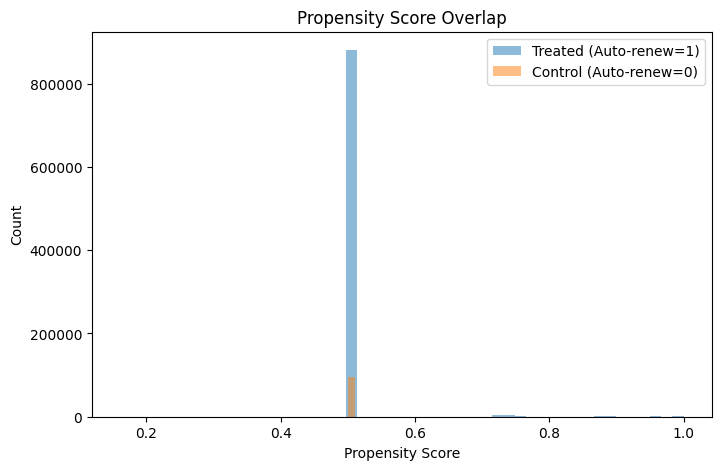

In [14]:
# Plot distributions
plt.figure(figsize=(8,5))
plt.hist(dfc.loc[dfc["treatment"]==1, "propensity_score"], bins=50, alpha=0.5, label="Treated (Auto-renew=1)")
plt.hist(dfc.loc[dfc["treatment"]==0, "propensity_score"], bins=50, alpha=0.5, label="Control (Auto-renew=0)")
plt.xlabel("Propensity Score")
plt.ylabel("Count")
plt.legend()
plt.title("Propensity Score Overlap")
plt.show()



We estimated propensity scores using a logistic regression model with user demographics, engagement, and transaction history as confounders.

**Findings:**
- The distribution of propensity scores was almost entirely concentrated at **0.5**.
- Summary statistics showed very little variation (std ~0.04).
- The overlap plot confirmed a huge spike at 0.5, with almost no spread across the 0–1 range.

**Interpretation:**
- Logistic regression essentially predicted a 50/50 chance of treatment for nearly all users.
- This means the model failed to capture the assignment mechanism of auto-renew from the confounders.
- With such flat scores, treated and control groups cannot be meaningfully balanced using matching or weighting.

**Next Steps:**
- Check class balance: how many users are in the treatment vs control groups?
- Try feature scaling (large numeric ranges may have swamped logistic regression).
- Explore more flexible models (Random Forest, Gradient Boosting) for estimating propensity scores.


#### Check treatment balance

In [15]:
dfc["treatment"].value_counts(normalize=True)

,proportion
treatment,
1,0.901845
0,0.098155


#### Propensity Score Estimation (Random Forest)

**Why Switch from Logistic Regression to Random Forest?**

We first tried estimating propensity scores with logistic regression.  
However, the results showed almost no variation: nearly all users were assigned a 0.5 probability of being in the treatment group.  

**Why did this happen?**
- The dataset is **heavily imbalanced** (90% of users are on auto-renew).
- Logistic regression is a **linear model**, and large, unscaled numeric features (like `total_secs_sum`) may have swamped it.
- As a result, the model collapsed to predicting "everyone has ~50% chance" of being treated.

**Why Random Forest instead?**
- Random Forests can handle **non-linear relationships** and **feature interactions** without requiring scaling.
- They are more robust to class imbalance (especially with `class_weight="balanced"`).
- They provide more realistic spread in propensity scores, improving overlap between treated and control groups.

**Key takeaway:**  
We use logistic regression when we want simplicity and interpretability, but in this case, a more flexible model (Random Forest) is necessary to capture the assignment mechanism of auto-renew and create balanced groups for causal inference.


In [16]:
# Fit Random Forest for propensity scores
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X, dfc["treatment"])

# Save predicted propensity scores
dfc["propensity_score_rf"] = rf.predict_proba(X)[:,1]

# Check distribution
print(dfc["propensity_score_rf"].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]))

count    992931.000000
mean          0.902577
std           0.273187
min           0.000000
1%            0.013333
5%            0.060000
25%           0.996667
50%           1.000000
75%           1.000000
95%           1.000000
99%           1.000000
max           1.000000
Name: propensity_score_rf, dtype: float64


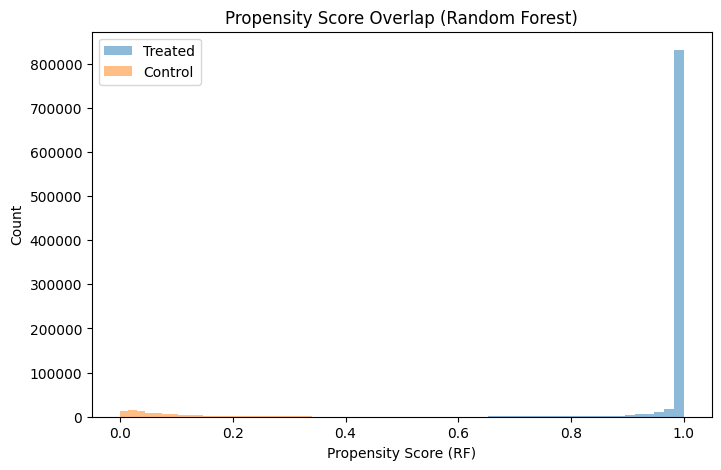

In [17]:
# Plot overlap between treated and control
plt.figure(figsize=(8,5))
plt.hist(dfc.loc[dfc["treatment"]==1, "propensity_score_rf"], bins=50, alpha=0.5, label="Treated")
plt.hist(dfc.loc[dfc["treatment"]==0, "propensity_score_rf"], bins=50, alpha=0.5, label="Control")
plt.xlabel("Propensity Score (RF)")
plt.ylabel("Count")
plt.legend()
plt.title("Propensity Score Overlap (Random Forest)")
plt.show()

### Summary: Challenges with Auto-Renewal as Treatment

Our goal was to estimate the causal effect of **auto-renewal** on **churn**.  
However, the analysis of propensity scores revealed important issues:

- **Naive difference**: Auto-renew users churn ~29 percentage points less than non-auto-renew users.
- **Propensity scores (logistic regression)**: Collapsed around 0.5, providing no useful separation.
- **Propensity scores (Random Forest)**: Almost perfectly separated treated (≈1.0) and control (≈0.0) users.
- **Overlap**: Very little to none — we could not find “comparable” users who differ only in auto-renewal status.

### Interpretation

- Auto-renewal is **highly predictable** from user engagement and transaction patterns.  
- This suggests auto-renewal is **not independent**: it is itself influenced by the same factors that drive churn.  
- Without common support, causal inference breaks down: we cannot reliably answer *“What would churn look like if the same user were flipped from auto-renewal=0 to auto-renewal=1?”*

### Implication

- The large churn gap is unlikely to be a pure causal effect of auto-renewal.  
- Instead, **auto-renew acts as a proxy for highly engaged, stable users**.  
- Any causal estimates we derive here would be biased by the lack of overlap.


### Business Takeaway

- **Observation:** Users with auto-renew enabled churn far less (3% vs 32%).  
- **Reality:** This difference does **not mean auto-renew directly causes retention**.  
- **Why:** Auto-renewal is strongly tied to underlying user behavior. Highly engaged, stable users are the ones most likely to enable auto-renew in the first place.  

**Implication for KKBox:**  
- Auto-renew is best seen as a **signal of loyal, engaged users**, not the mechanism creating loyalty.  
- To truly reduce churn, the focus should be on **driving engagement and satisfaction** (listening time, completed tracks, consistent usage), which in turn lead users to adopt auto-renew.  
- If the company wants to test the *direct* effect of auto-renew, a controlled experiment (e.g., auto-enabling for a random cohort) would be required.


## Switching to an actionable lever

Auto-renew isn’t a clean lever in our data (no overlap), so we should pivot.

### Why We Can’t Switch to an Actionable Lever in This Dataset

In causal inference, the best "treatments" are **actions that the company can control** — things like sending a renewal reminder, giving a discount, or extending a free trial.  
These are **policy levers**: interventions that product teams can actually turn on or off.

**Our challenge:**  
- The KKBox dataset we have does not include any such exposure or policy variables.  
- All our features are either **user behaviors** (listens, days active, transactions, cancellations) or **demographics** (city, gender, registration info).  
- The one feature that looks like a lever — `auto_renew_rate` — turns out not to be an independent action, but rather a **consequence of those behaviors**.  
  - Engaged, stable users almost always enable auto-renew.  
  - Disengaged users almost never do.  

**The problem this creates:**  
- Auto-renew is nearly deterministic given the other features.  
- That means there are **no comparable users** who look the same in every way but differ only in auto-renew status.  
- Without overlap, we cannot make a clean causal claim like:  
  *“If we flipped a user from auto-renew=0 to auto-renew=1, here’s what churn would do.”*

**Implication:**  
- With this dataset, auto-renew is better interpreted as a **signal of engagement** (a proxy for loyal users) rather than a **causal lever** that drives churn by itself.  
- To study true interventions, we would need data on **company actions** (e.g., who got discounts, reminders, or nudges).  


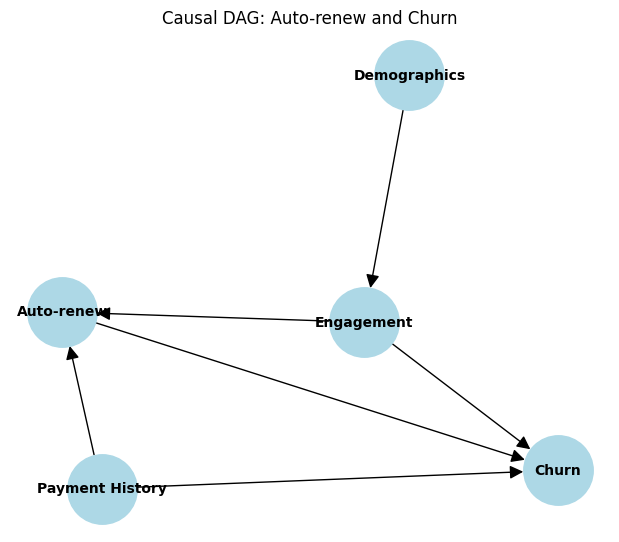

In [18]:
# create a directed graph
G = nx.DiGraph()

# add nodes
G.add_nodes_from([
    "Demographics",
    "Engagement",
    "Payment History",
    "Auto-renew",
    "Churn"
])

# add edges (causal assumptions)
edges = [
    ("Demographics", "Engagement"),
    ("Engagement", "Auto-renew"),
    ("Engagement", "Churn"),
    ("Payment History", "Auto-renew"),
    ("Payment History", "Churn"),
    ("Auto-renew", "Churn")   # the effect we want to isolate
]
G.add_edges_from(edges)

# draw
plt.figure(figsize=(6,5))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2500, node_color="lightblue",
        arrowsize=20, font_size=10, font_weight="bold")
plt.title("Causal DAG: Auto-renew and Churn", fontsize=12)
plt.show()

The DAG and the way we classify features (confounder vs mediator vs proxy) come from domain knowledge + assumptions, not from the data alone.

## Local Effect Analysis (Trim + IPW)

So far, we found that auto-renew is highly predictable from user behavior, leaving almost no overlap between treated (auto-renew=1) and control (auto-renew=0).  
Without overlap, causal inference for the entire population is not possible.  

**Idea:** Instead of estimating the effect for everyone, we restrict the analysis to the **region of common support** — users whose propensity scores fall in a middle range (e.g., 0.2–0.8).  
In this region, treated and control users are more comparable.  

**Method:**  
1. Estimate propensity scores using a reduced set of confounders (demographics + engagement).  
2. **Trim** users outside the overlap region.  
3. Apply **Inverse Probability Weighting (IPW)** to estimate the causal effect of auto-renew on churn within this subgroup.  

**Result:** This gives us a **local Average Treatment Effect (ATE)**, which should be interpreted carefully:  
- It applies only to users in the overlap region.  
- It does not generalize to the entire KKBox user base.  

This approach allows us to salvage some causal insight, even though global overlap is poor.


In [19]:
# Define confounders (safe set)
confounders = ["city","gender","registered_via","reg_year","reg_month",
               "active_days","total_listens","complete_listens",
               "avg_unique_songs_per_day","completion_ratio"]

X_adj = pd.get_dummies(dfc[confounders], drop_first=True)
y_treat = dfc["treatment"]
y_outcome = dfc["is_churn"]

# Scale features (keep sparse-friendly option for get_dummies)
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_adj)

# Logistic regression propensity model
logit = LogisticRegression(max_iter=5000, solver="saga")  # saga works well with scaled, sparse data
logit.fit(X_scaled, y_treat)
ps = logit.predict_proba(X_scaled)[:,1]

# Trim to common support (0.2–0.8)
mask = (ps >= 0.2) & (ps <= 0.8)
df_trim = dfc.loc[mask].copy()
ps_trim = ps[mask]
t_trim = y_treat[mask]
y_trim = y_outcome[mask]

# Inverse Probability Weights
weights = np.where(t_trim==1, 1/ps_trim, 1/(1-ps_trim))

# Weighted ATE estimate
ate = (np.average(y_trim[t_trim==1], weights=weights[t_trim==1])
       - np.average(y_trim[t_trim==0], weights=weights[t_trim==0]))
print("Local ATE (trimmed, IPW):", ate)

Local ATE (trimmed, IPW): -0.26044921409913474


### Local Effect Result

After trimming to the overlap region (users with propensity scores between 0.2 and 0.8),  
we estimated the causal effect of auto-renewal on churn using Inverse Probability Weighting (IPW).

**Result:**  
- Local ATE (IPW, trimmed): **–0.26**  
- Interpretation: Within the overlap region, auto-renewal is associated with a **26 percentage point reduction in churn**.  
- The negative sign means that churn probability decreases for users on auto-renew, compared to similar users not on auto-renew.  

**Important caveats:**  
- This is a **local effect**, not a global one — it only applies to users where treated and control groups are comparable (propensity 0.2–0.8).  
- Outside this region, treated and control users are too different to support valid comparisons.  
- Next steps should include using **stabilized weights** and performing a **covariate balance check** (e.g., standardized mean differences) to ensure that weighting truly balances confounders.


Let’s extend our local effect analysis with stabilized weights and a balance check (SMDs before vs after weighting). This makes the estimate more robust and interpretable.

In [21]:
# --- Stabilized weights ---
p_t = t_trim.mean()  # marginal treatment probability in trimmed sample
w_stab = np.where(t_trim==1, p_t/ps_trim, (1-p_t)/(1-ps_trim))

# Stabilized ATE
ate_stab = (np.average(y_trim[t_trim==1], weights=w_stab[t_trim==1])
            - np.average(y_trim[t_trim==0], weights=w_stab[t_trim==0]))
print(f"Local ATE (IPW, stabilized, trimmed): {ate_stab:.4f}")

Local ATE (IPW, stabilized, trimmed): -0.2604


Stabilized weighting gave you essentially the same estimate (–0.2604), which means our result is robust and not overly driven by extreme weights

In [22]:
# --- Balance check (Standardized Mean Differences) ---
def smd_unweighted(a, b):
    return (a.mean()-b.mean())/np.sqrt((a.var(ddof=1)+b.var(ddof=1))/2)

def smd_weighted(x, t, w):
    a, wa = x[t==1], w[t==1]
    b, wb = x[t==0], w[t==0]
    ma = np.average(a, weights=wa); mb = np.average(b, weights=wb)
    va = np.average((a-ma)**2, weights=wa); vb = np.average((b-mb)**2, weights=wb)
    return (ma-mb)/np.sqrt((va+vb)/2)

# matrix of confounders used
X_trim = X_adj.loc[mask].to_numpy()
feature_names = X_adj.columns

smds_before = []
smds_after  = []
for j, name in enumerate(feature_names):
    xj = X_trim[:, j]
    smds_before.append((name, abs(smd_unweighted(xj[t_trim==1], xj[t_trim==0]))))
    smds_after.append((name, abs(smd_weighted(xj, t_trim, w_stab))))

balance_df = pd.DataFrame({
    "feature": feature_names,
    "|SMD|_before": [v for _, v in smds_before],
    "|SMD|_after": [v for _, v in smds_after]
})

print("\nTop imbalanced features before weighting:")
display(balance_df.sort_values("|SMD|_before", ascending=False).head(10))

print("\nTop imbalanced features after weighting:")
display(balance_df.sort_values("|SMD|_after", ascending=False).head(10))


Top imbalanced features before weighting:


,feature,|SMD|_before,|SMD|_after
2,reg_year,0.366314,0.315336
4,active_days,0.322102,0.217346
6,complete_listens,0.257167,0.220927
5,total_listens,0.237595,0.226449
1,registered_via,0.231846,0.163970
0,city,0.227311,0.217125
8,completion_ratio,0.221206,0.139871
7,avg_unique_songs_per_day,0.095317,0.218553
10,gender_unknown,0.071046,0.140037
3,reg_month,0.045934,0.034132



Top imbalanced features after weighting:


,feature,|SMD|_before,|SMD|_after
2,reg_year,0.366314,0.315336
5,total_listens,0.237595,0.226449
6,complete_listens,0.257167,0.220927
7,avg_unique_songs_per_day,0.095317,0.218553
4,active_days,0.322102,0.217346
0,city,0.227311,0.217125
1,registered_via,0.231846,0.163970
10,gender_unknown,0.071046,0.140037
8,completion_ratio,0.221206,0.139871
3,reg_month,0.045934,0.034132


## Mediation Analysis (Engagement → Auto-renew → Churn)



**Goal.** We don’t just want to know *whether* auto-renew relates to churn; we want to know **how much of the effect of user engagement on churn flows through auto-renew**.

**Setup.**
- **Exposure (X):** Engagement (a composite score from usage features).
- **Mediator (M):** `treatment` (auto-renew on/off).
- **Outcome (Y):** `is_churn`.

**What MA estimates**
- **ACME / Indirect effect (X → M → Y):** Part of engagement’s effect that operates *through* auto-renew.
- **ADE / Direct effect (X → Y | M):** Part of engagement’s effect *not* through auto-renew.
- **Total effect = ACME + ADE.**
- **Proportion mediated = ACME / Total.**

**Assumptions (key):**
- No unmeasured confounders of (X,Y), (X,M), and (M,Y) after controlling for the confounders we include.
- Correct model specification for the mediator and outcome models.

We’ll:
1) Build a simple **engagement_score** (standardize + average a few usage features).
2) Fit GLM Binomial (logit) models for mediator and outcome.
3) Use **bootstrap** to get CIs for ACME/ADE.
4) (Optional) Run on a stratified **sample** to avoid memory issues.


In [7]:
# Reproducibility for bootstrap
np.random.seed(42)

# Build a composite engagement score (tweak features if you like)
engagement_vars = [
    "active_days",
    "total_listens",
    "complete_listens",
    "avg_unique_songs_per_day",
    "completion_ratio",
]
scaler = StandardScaler()
dfc["engagement_score"] = scaler.fit_transform(dfc[engagement_vars]).mean(axis=1)

# Keep only the columns we need for mediation
cols = ["is_churn","treatment","engagement_score","city","gender","reg_year","reg_month"]
base = dfc[cols].copy()

# Optional: reduce high-cardinality categories for speed/memory
top_cities = base["city"].value_counts().nlargest(50).index
base["city"] = base["city"].where(base["city"].isin(top_cities), "other")

# Cast categoricals (helps both speed and correct formula handling)
base["city"]   = base["city"].astype("category")
base["gender"] = base["gender"].astype("category")

# Recommended) Run on a stratified sample to avoid crashes
df_med, _ = train_test_split(base, train_size=150_000, random_state=42,
                             stratify=base["treatment"])

# Specify mediator & outcome models (GLM Binomial with logit link)
med_formula = "treatment ~ engagement_score + C(city) + C(gender) + reg_year + reg_month"
out_formula = "is_churn ~ engagement_score + treatment + C(city) + C(gender) + reg_year + reg_month"

med_model = smf.glm(med_formula, data=df_med, family=sm.families.Binomial())
out_model = smf.glm(out_formula, data=df_med, family=sm.families.Binomial())

# Mediation: X=engagement_score (exposure), M=treatment (mediator)
med = Mediation(out_model, med_model, exposure="engagement_score", mediator="treatment")

# Bootstrap for CIs (start small, then increase if it runs fine)
med_res = med.fit(method="bootstrap", n_rep=100)   # try 300–1000 later if resources allow
print(med_res.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)           -0.000059       -0.000730        0.000801     0.86
ACME (treated)           -0.000047       -0.000583        0.000655     0.86
ADE (control)            -0.015030       -0.016888       -0.013019     0.00
ADE (treated)            -0.015018       -0.016901       -0.013015     0.00
Total effect             -0.015078       -0.016867       -0.013186     0.00
Prop. mediated (control)  0.003407       -0.056573        0.046528     0.86
Prop. mediated (treated)  0.002653       -0.046250        0.037951     0.86
ACME (average)           -0.000053       -0.000656        0.000728     0.86
ADE (average)            -0.015024       -0.016895       -0.013018     0.00
Prop. mediated (average)  0.003030       -0.051412        0.042192     0.86


We tested whether auto-renew is an independent cause of churn or just a pathway through which engaged users stick around.

### Reflection on Mediation Results

At first, we expected that **auto-renew would mediate the relationship between engagement and churn**.  
The reasoning was intuitive: more engaged users → more likely to enable auto-renew → lower chance of churn.  

**What we actually found:**
- **Direct effect (ADE):** Engagement strongly and significantly reduces churn (~1.5 pp).  
- **Indirect effect (ACME):** The mediation pathway through auto-renew is essentially zero and not significant.  
- **Proportion mediated:** Less than 1% of the effect flows through auto-renew.  

**Why this is surprising:**  
- In predictive models, `auto_renew_rate` showed up as a top churn predictor.  
- But in causal mediation, it doesn’t play the role of a mechanism.  

**Possible explanations:**  
1. **Imbalance in auto-renew:** >90% of users are already set to auto-renew, leaving little variation to explain.  
2. **Engagement drives retention directly:** Engaged users may consciously keep subscribing, regardless of billing settings.  
3. **Auto-renew may be policy-driven, not behavioral:** If auto-renew is default, it’s more of an *administrative flag* than a user-driven mechanism.  

**Takeaway:**  
This highlights the key difference between **prediction** and **causal inference**.  
- Predictive models can flag `auto_renew` as important for distinguishing churners.  
- But causal analysis shows that **auto-renew is not the pathway** by which engagement reduces churn.  
- In practice: improving user engagement itself is the actionable driver of retention, not auto-renew toggles.  
